In [7]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [8]:
CURATED_DATA_34_PATH = "curated_34.csv"

curated_data_34 = pd.read_csv(CURATED_DATA_34_PATH)

In [9]:
curated_data_34

,valeur_fonciere,longitude,latitude,nombre_pieces_principales,surface_reelle_bati,code_postal,nom_commune,valeur_mc
0,158730.0,4.086656,43.558880,1.0,25.0,34280.0,La Grande-Motte,6349.200000
1,82000.0,3.891022,43.590893,1.0,21.0,34070.0,Montpellier,3904.761905
2,76000.0,3.846555,43.619867,1.0,30.0,34080.0,Montpellier,2533.333333
3,218500.0,3.886218,43.606132,3.0,70.0,34000.0,Montpellier,3121.428571
4,150000.0,3.695132,43.400797,3.0,36.0,34200.0,Sète,4166.666667
...,...,...,...,...,...,...,...,...
1162,54150.0,3.213315,43.345102,3.0,30.0,34500.0,Béziers,1805.000000
1163,114000.0,3.215119,43.340108,3.0,91.0,34500.0,Béziers,1252.747253
1164,74000.0,3.216692,43.339397,2.0,50.0,34500.0,Béziers,1480.000000
1165,180500.0,3.521735,43.284802,2.0,45.0,34300.0,Agde,4011.111111


# Relations analysis

<Axes: xlabel='nombre_pieces_principales', ylabel='valeur_mc'>

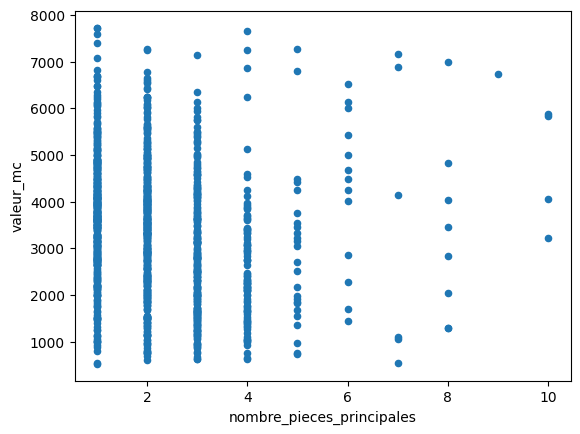

In [10]:
curated_data_34.plot(y="valeur_mc", x="nombre_pieces_principales", kind="scatter")

<Axes: title={'center': 'valeur_mc'}, xlabel='nombre_pieces_principales'>

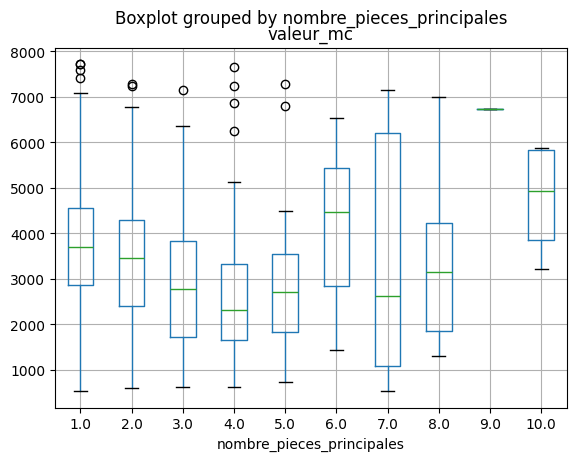

In [11]:
curated_data_34.boxplot("valeur_mc", by="nombre_pieces_principales")

<Axes: xlabel='surface_reelle_bati', ylabel='valeur_mc'>

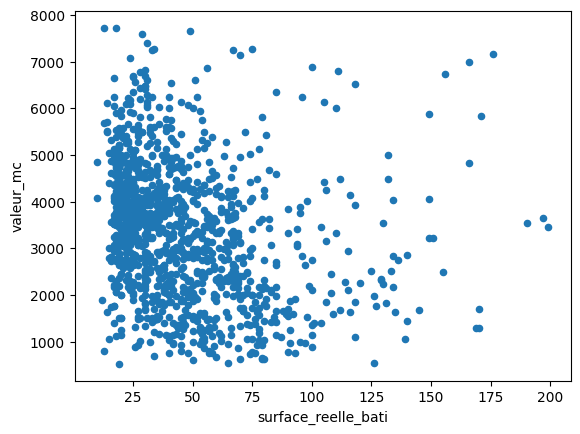

In [12]:
curated_data_34.plot(y="valeur_mc", x="surface_reelle_bati", kind="scatter")

In [13]:
pd.qcut(curated_data_34["surface_reelle_bati"], q=10, labels=list(range(0,10)))

0       2
1       1
2       3
3       8
4       4
       ..
1162    3
1163    9
1164    6
1165    5
1166    8
Name: surface_reelle_bati, Length: 1167, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [14]:
curated_data_34["surface_reelle_bati_qcut"] = pd.qcut(curated_data_34["surface_reelle_bati"], q=10, labels=list(range(0,10)))




<Axes: title={'center': 'valeur_mc'}, xlabel='surface_reelle_bati_qcut'>

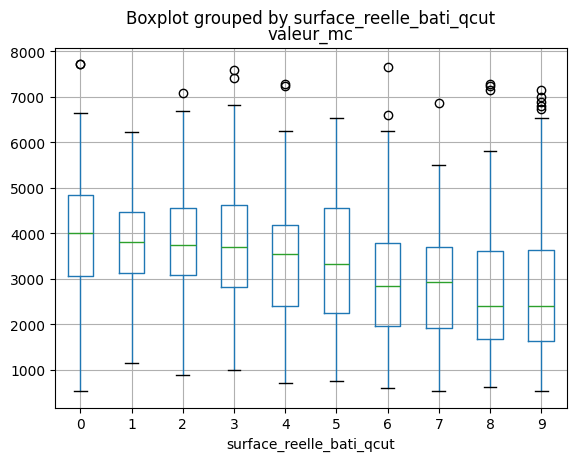

In [20]:
curated_data_34.boxplot("valeur_mc", by="surface_reelle_bati_qcut")

# Test train split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
target = "valeur_mc"

In [23]:
features = ["surface_reelle_bati", "nombre_pieces_principales", "longitude", "latitude"]

In [24]:
data_train, data_test = train_test_split(
    curated_data_34, test_size=0.33, random_state=42)

In [25]:
data_train.shape

(781, 9)

In [26]:
data_test.shape

(386, 9)

# Average per CP model : the benchmark

In [27]:
mean_per_cp = data_train.groupby('code_postal')['valeur_mc'].mean().to_frame()\
    .rename(columns={'valeur_mc': 'cp_mean_prediction'})

In [28]:
mean_per_cp.head()

,cp_mean_prediction
code_postal,
34000.0,4011.896004
34070.0,3047.090271
34080.0,2226.783652
34090.0,3861.597892
34110.0,3523.260666


## Merge predictions

In [29]:
data_test = data_test.merge(mean_per_cp, on="code_postal")

In [30]:
data_test['mean_per_cp_percent_error'] = np.abs(data_test["cp_mean_prediction"] - data_test["valeur_mc"])/data_test["valeur_mc"]



In [31]:
data_test['mean_per_cp_percent_error'].describe()

count    378.000000
mean       0.335963
std        0.423496
min        0.000745
25%        0.095478
50%        0.223397
75%        0.401977
max        3.525863
Name: mean_per_cp_percent_error, dtype: float64

# Full random forest model

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [33]:
model = GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000, random_state=42),
                     scoring='neg_root_mean_squared_error',
                     param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [34]:
model.fit(data_train[features], 
          data_train[target])

GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [35]:
model.cv_results_

{'mean_fit_time': array([5.42099628, 6.80058651, 3.57972817, 3.42370739, 2.88139439,
        3.56999955, 3.15779986, 2.68619781, 2.90719886, 2.73039908]),
 'std_fit_time': array([0.40352161, 1.58028925, 0.98402856, 0.47409353, 0.23271993,
        0.92622879, 0.67863158, 0.0997699 , 0.28116461, 0.26278248]),
 'mean_score_time': array([0.13619952, 0.21480155, 0.08579283, 0.09120245, 0.08780041,
        0.1216012 , 0.08160677, 0.08220291, 0.07340126, 0.08339834]),
 'std_score_time': array([0.02142061, 0.07248687, 0.00895504, 0.0118209 , 0.01890529,
        0.06475917, 0.01147974, 0.01352669, 0.00652739, 0.01047847]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 4},
  {'min_samples_leaf': 5},
  {'min_samples_

In [36]:
model.best_estimator_

RandomForestRegressor(min_samples_leaf=5, n_estimators=1000, random_state=42)

In [37]:
model.predict(data_test[features])[:10]

array([1456.63424976, 3202.44463309, 2936.77183981, 3847.71575534,
       1721.70274537, 3983.62609516, 2344.0776778 , 3935.10265347,
       4200.29225304, 4895.08594567])

In [38]:
data_test["rf_prediction"] = model.predict(data_test[features])

In [39]:
data_test["rf_precent_error"] =  np.abs(data_test["rf_prediction"] - data_test["valeur_mc"])/data_test["valeur_mc"]



In [40]:
data_test["rf_precent_error"].describe()

count    378.000000
mean       0.290343
std        0.406580
min        0.000074
25%        0.091992
50%        0.185607
75%        0.324190
max        4.108915
Name: rf_precent_error, dtype: float64

In [41]:
data_test[data_test["rf_precent_error"] > 1]

,valeur_fonciere,longitude,latitude,nombre_pieces_principales,surface_reelle_bati,code_postal,nom_commune,valeur_mc,surface_reelle_bati_qcut,cp_mean_prediction,mean_per_cp_percent_error,rf_prediction,rf_precent_error
4,44000.0,3.155543,43.616378,2.0,58.0,34600.0,Bédarieux,758.620690,7,1391.588120,0.834366,1721.702745,1.269517
32,68000.0,3.281196,43.314838,7.0,126.0,34420.0,Villeneuve-lès-Béziers,539.682540,9,2011.039272,2.726337,2757.192244,4.108915
49,70000.0,3.845393,43.620704,5.0,93.0,34080.0,Montpellier,752.688172,9,2226.783652,1.958441,1982.293961,1.633619
55,77000.0,3.233289,43.353894,4.0,73.0,34500.0,Béziers,1054.794521,8,1882.564996,0.784769,2250.240888,1.133345
70,40000.0,3.220226,43.341772,3.0,60.0,34500.0,Béziers,666.666667,7,1882.564996,1.823847,1567.932528,1.351899
75,51500.0,3.818512,43.638439,4.0,79.0,34080.0,Montpellier,651.898734,8,2226.783652,2.415843,1977.161047,2.032927
125,37000.0,3.872398,43.607581,2.0,18.0,34000.0,Montpellier,2055.555556,0,4011.896004,0.951733,4879.464754,1.373794
129,65200.0,3.549413,43.315371,1.0,27.0,34340.0,Marseillan,2414.814815,2,3661.013642,0.516064,5162.277276,1.137753
183,65000.0,3.278546,43.283023,3.0,53.0,34410.0,Sérignan,1226.415094,6,2073.304348,0.690540,2781.211271,1.267757
200,290000.0,3.873948,43.621084,6.0,170.0,34090.0,Montpellier,1705.882353,9,3861.597892,1.263695,3421.427655,1.005664


# GPS (Latitude longitude) RF only

In [42]:
model_gps = GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000, random_state=42),
                     scoring='neg_root_mean_squared_error',
                     param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [43]:
model_gps.fit(data_train[["longitude", "latitude"]], 
              data_train[target])

GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [44]:
model_gps.best_estimator_

RandomForestRegressor(min_samples_leaf=6, n_estimators=1000, random_state=42)

In [45]:
model_gps.cv_results_

{'mean_fit_time': array([3.52642598, 2.91380215, 2.74700193, 2.63360014, 2.67599773,
        2.4792037 , 2.32160053, 2.43619804, 2.5396008 , 2.4463995 ]),
 'std_fit_time': array([0.34277976, 0.21158146, 0.22467936, 0.18511547, 0.26731761,
        0.20870013, 0.02531736, 0.32514139, 0.19848759, 0.23621258]),
 'mean_score_time': array([0.1154007 , 0.0935977 , 0.09500079, 0.08480167, 0.09760389,
        0.08280096, 0.09020128, 0.09400148, 0.0871974 , 0.09159937]),
 'std_score_time': array([0.01720177, 0.00682748, 0.01680365, 0.00733102, 0.02623196,
        0.00406977, 0.01108849, 0.02865629, 0.00945511, 0.00646923]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 4},
  {'min_samples_leaf': 5},
  {'min_samples_

In [46]:
model_gps.predict(data_test[["longitude", "latitude"]])[:10]

array([1303.94039573, 3101.30596774, 2195.21253841, 4105.73416257,
       1885.04781891, 3753.37637683, 2338.22332404, 3818.43464395,
       3784.87191878, 4425.80624153])

In [47]:
data_test['rf_gps_predictions'] = model_gps.predict(data_test[["longitude", "latitude"]])

In [48]:
data_test["rf_gps_precent_error"] =  np.abs(data_test["rf_gps_predictions"] - data_test["valeur_mc"])/data_test["valeur_mc"]


In [49]:
data_test['rf_gps_precent_error'].describe()

count    378.000000
mean       0.297809
std        0.387193
min        0.000354
25%        0.094832
50%        0.184300
75%        0.340707
max        3.190300
Name: rf_gps_precent_error, dtype: float64

# Business simulation 

## Assumptions

In [50]:
user_predictions_per_month = 1000

In [51]:
accuracy_thereshold = 0.05 #  an accurate prediction is 5%

In [52]:
accurate_prediction_conversion_rate = 0.01  # 1% conversion rate for accurate predictions

In [53]:
client_fees_on_value = 0.03

In [54]:
average_house_price = 150000 # Could be different for each since model

## Computations

In [55]:
average_cp_accuracy = (data_test["mean_per_cp_percent_error"] < accuracy_thereshold).mean()


In [56]:
average_cp_accuracy

0.1402116402116402

In [57]:
average_rf_accuracy = (data_test["rf_precent_error"] < accuracy_thereshold).mean()


In [58]:
average_rf_accuracy

0.16137566137566137

In [59]:
average_gps_rf_accuracy = (data_test["rf_gps_precent_error"] < accuracy_thereshold).mean()


In [60]:
average_gps_rf_accuracy

0.1349206349206349

# Results

In [61]:
user_predictions_per_month*average_cp_accuracy*accurate_prediction_conversion_rate*average_house_price*client_fees_on_value



6309.523809523809

In [62]:
user_predictions_per_month*average_rf_accuracy*accurate_prediction_conversion_rate*average_house_price*client_fees_on_value


7261.9047619047615

In [63]:
user_predictions_per_month*average_gps_rf_accuracy*accurate_prediction_conversion_rate*average_house_price*client_fees_on_value


6071.428571428571